In [ ]:
from dustbi_simulator import *
from Functions import *

In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv("INPUT_DES5YR_D2D.FITRES", comment="#", sep='\s+')

df['SIM_EBV'] = df.SIM_AV/df.SIM_RV


dfdata = pd.read_csv("SIMS_FOR_TESTING/FITOPT000.FITRES.gz", 
                     comment="#", sep=r'\s+')

try:
    dfdata['SIM_EBV'] = dfdata.SIM_AV/dfdata.SIM_RV
except:
    print("eh.")

dfdata = dfdata.loc[dfdata.IDSURVEY == 10]
dfdata = dfdata.loc[dfdata.PROB_SNNV19 >= 0.5]

/Users/bpopovic/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [135]:
bounds_dict = {
    "SIM_c"   : (-0.5, 0.5),
    "SIM_RV"  : (1.5, 5),
    "SIM_EBV" : (0,1),
    "SIM_beta": (0.5,4),
}

function_dict = {
    "SIM_c"   : DistGaussian,
    "SIM_RV"  : DistGaussian,
    "SIM_EBV" : DistExponential,
    "SIM_beta": DistGaussian,
}

split_dict = {
    "SIM_RV":["HOST_LOGMASS", 10],
#    "SIM_EBV":['HOST_LOGMASS', 10],
}


#Prior dict is a weird one; it should be a tuple for each parameter and then a boolean statement.

#split_dict = {}


priors_dict = {
    
    "SIM_c"   : [(-0.2, 0), (0.0, 0.1), False],
    "SIM_RV"  : [(1.5,4), (0,2), True],
    "SIM_EBV" : [(0.05, 0.3)],
    "SIM_beta": [(0,3), (0,1), True],
    
}

latex_dict = {
    
    'DistExponential':[r'$\tau$'],
    'DistGaussian':[r'$\mu$', r'$\sigma$'],
    'SIM_c':r"$c_{\rm int}$",
    'SIM_beta':r"$\beta_{\rm int}$",
    'SIM_RV':r"$R_V$",
    'SIM_EBV':r"$EBV$",
    
}


dicts = [bounds_dict, function_dict, split_dict, priors_dict]

Total priors added: 10
[0] <class 'sbi.utils.torchutils.BoxUniform'>
[1] <class 'sbi.utils.torchutils.BoxUniform'>
[2] <class 'sbi.utils.torchutils.BoxUniform'>
[3] <class 'sbi.utils.torchutils.BoxUniform'>
[4] <class 'sbi.utils.torchutils.BoxUniform'>
[5] <class 'sbi.utils.torchutils.BoxUniform'>
[6] <class 'sbi.utils.torchutils.BoxUniform'>
[7] <class 'sbi.utils.torchutils.BoxUniform'>
[8] <class 'sbi.utils.torchutils.BoxUniform'>
[9] <class 'sbi.utils.torchutils.BoxUniform'>


In [42]:
layout = build_layout(params_to_fit, dicts)

In [121]:
param_names = ['SIM_c', 'SIM_RV', 'SIM_beta', 'SIM_EBV']
#param_names = ['SIM_c']




In [43]:
simulatinator = make_simulator(layout, df, param_names, dicts, dfdata)


In [44]:
parameters_to_condition_on = ['c', 'mB']

In [45]:
def batched_simulator(theta_batch):
    return torch.stack([simulatinator(theta) for theta in theta_batch])

In [46]:
from sbi import analysis as analysis

# sbi
from sbi import utils as utils
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [47]:
# Check prior, simulator, consistency
prior, num_parameters, prior_returns_numpy = process_prior(priors)
simulation_wrapper = process_simulator(simulatinator, prior, prior_returns_numpy)
check_sbi_inputs(simulation_wrapper, prior)

# Original, simpler version - need to move to its own class 

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F




In [ ]:
from sbi.inference import SNPE
from sbi.utils import MultipleIndependent

from sbi.neural_nets import posterior_nn




# Potentially Upgraded Version

In [140]:
class PopulationEmbeddingFull(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=32):
        super().__init__()
        self.phi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.rho = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # x: (batch_size, N, 2)
        h = self.phi(x)           # (batch_size, N, hidden_dim)
        h = h.mean(dim=1)         # mean over N samples -> (batch_size, hidden_dim)
        return self.rho(h)        # (batch_size, output_dim)


In [141]:
from sbi.inference import SNPE
from sbi.utils import MultipleIndependent

from sbi.neural_nets import posterior_nn

density_estimator = posterior_nn(
    model="nsf", #switch to nsf if interested 
    embedding_net=PopulationEmbeddingFull(input_dim=4)
)

inference = SNPE(
    prior=priors,
    density_estimator=density_estimator, 
)





In [52]:
import torch
import os

batch_size = 100
num_simulations = 6000
save_path = "simulations_v1.pt"

# If the file already exists, start fresh
if os.path.exists(save_path):
    os.remove(save_path)

for start in range(0, num_simulations, batch_size):
    current_bs = min(batch_size, num_simulations - start)

    # Sample and simulate
    theta_batch = priors.sample((current_bs,))
    x_batch = batched_simulator(theta_batch)

    # Append to SBI inference
    inference.append_simulations(theta_batch, x_batch)

    # Save incrementally
    if start == 0:
        # First batch, create the file
        torch.save({'theta': theta_batch, 'x': x_batch}, save_path)
    else:
        # Load existing data
        data = torch.load(save_path)
        data['theta'] = torch.cat([data['theta'], theta_batch], dim=0)
        data['x'] = torch.cat([data['x'], x_batch], dim=0)
        torch.save(data, save_path)

    print(f"Appended {start + current_bs}/{num_simulations} simulations and saved incrementally.")

print(f"All simulations saved incrementally to '{save_path}'")


Appended 100/6000 simulations and saved incrementally.


/var/folders/2p/hm6bd5n17d5g5kpsm6s7vf3r0002g2/T/ipykernel_68265/2984509352.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(save_path)


Appended 200/6000 simulations and saved incrementally.


Appended 300/6000 simulations and saved incrementally.


Appended 400/6000 simulations and saved incrementally.


Appended 500/6000 simulations and saved incrementally.


Appended 600/6000 simulations and saved incrementally.
Appended 700/6000 simulations and saved incrementally.


Appended 800/6000 simulations and saved incrementally.


Appended 900/6000 simulations and saved incrementally.


Appended 1000/6000 simulations and saved incrementally.


Appended 1100/6000 simulations and saved incrementally.


Appended 1200/6000 simulations and saved incrementally.


Appended 1300/6000 simulations and saved incrementally.


Appended 1400/6000 simulations and saved incrementally.


Appended 1500/6000 simulations and saved incrementally.


Appended 1600/6000 simulations and saved incrementally.


Appended 1700/6000 simulations and saved incrementally.


Appended 1800/6000 simulations and saved incrementally.


Appended 1900/6000 simulations and saved incrementally.


Appended 2000/6000 simulations and saved incrementally.


Appended 2100/6000 simulations and saved incrementally.


Appended 2200/6000 simulations and saved incrementally.


Appended 2300/6000 simulations and saved incrementally.


Appended 2400/6000 simulations and saved incrementally.


Appended 2500/6000 simulations and saved incrementally.


Appended 2600/6000 simulations and saved incrementally.


Appended 2700/6000 simulations and saved incrementally.


Appended 2800/6000 simulations and saved incrementally.


Appended 2900/6000 simulations and saved incrementally.


Appended 3000/6000 simulations and saved incrementally.


Appended 3100/6000 simulations and saved incrementally.


Appended 3200/6000 simulations and saved incrementally.


Appended 3300/6000 simulations and saved incrementally.


Appended 3400/6000 simulations and saved incrementally.
Appended 3500/6000 simulations and saved incrementally.


Appended 3600/6000 simulations and saved incrementally.


Appended 3700/6000 simulations and saved incrementally.


Appended 3800/6000 simulations and saved incrementally.


Appended 3900/6000 simulations and saved incrementally.


Appended 4000/6000 simulations and saved incrementally.


Appended 4100/6000 simulations and saved incrementally.


Appended 4200/6000 simulations and saved incrementally.


Appended 4300/6000 simulations and saved incrementally.


Appended 4400/6000 simulations and saved incrementally.


Appended 4500/6000 simulations and saved incrementally.


Appended 4600/6000 simulations and saved incrementally.


Appended 4700/6000 simulations and saved incrementally.


Appended 4800/6000 simulations and saved incrementally.


Appended 4900/6000 simulations and saved incrementally.


Appended 5000/6000 simulations and saved incrementally.


Appended 5100/6000 simulations and saved incrementally.


Appended 5200/6000 simulations and saved incrementally.


Appended 5300/6000 simulations and saved incrementally.


Appended 5400/6000 simulations and saved incrementally.


Appended 5500/6000 simulations and saved incrementally.


Appended 5600/6000 simulations and saved incrementally.


Appended 5700/6000 simulations and saved incrementally.


Appended 5800/6000 simulations and saved incrementally.


Appended 5900/6000 simulations and saved incrementally.


Appended 6000/6000 simulations and saved incrementally.
All simulations saved incrementally to 'simulations_v1.pt'


In [53]:
inference.append_simulations(theta_batch, x_batch)

density_estimator = inference.train()

print("\n inferred successfully")

posterior = inference.build_posterior(density_estimator)

torch.save(posterior, "posterior.pt")


 Neural network successfully converged after 146 epochs.
 inferred successfully


In [28]:
data = torch.load("simulations_v1.pt")
theta_batch = data["theta"]
x_batch = data["x"]


/var/folders/2p/hm6bd5n17d5g5kpsm6s7vf3r0002g2/T/ipykernel_68265/132003545.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("simulations_v1.pt")


In [54]:
parameters_to_condition_on = ['c', 'mB']
output_distribution = preprocess_input_distribution(dfdata, parameters_to_condition_on)

empty_list = []
for final_param in parameters_to_condition_on:
    empty_list.append(output_distribution[final_param])

x = torch.stack(empty_list, dim=-1)

In [127]:
labels = unspool_labels(param_names, dicts, latex_dict)

In [128]:
posterior_samples = posterior.sample((50000,), x=x)


51161it [00:00, 177554.84it/s]                                                  


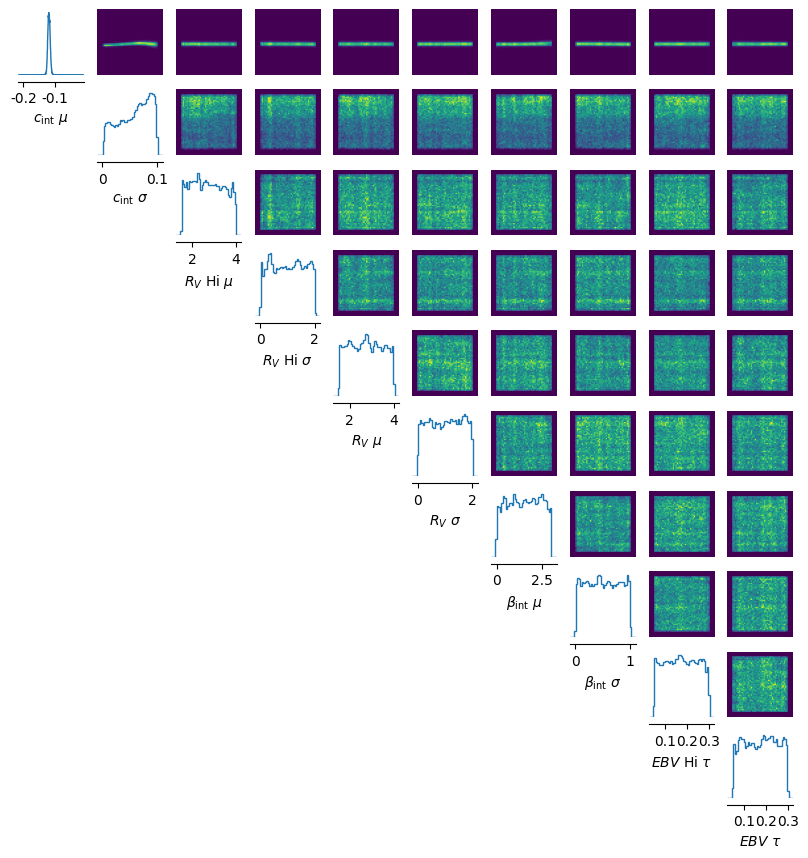

In [129]:
fig, axes = analysis.pairplot(
    posterior_samples,
    labels=labels

);

In [61]:
theta_hat = posterior_samples.mean(0)


In [62]:
theta_hat


tensor([-0.1191,  0.0576,  2.7109,  1.0010,  2.7327,  1.0090,  1.5164,  0.5012,
         0.1743,  0.1764])

In [38]:
posterior_samples.std(0)

tensor([0.0154, 0.0264, 0.7054, 0.5562, 0.8331, 0.2742, 0.0177])

In [23]:
from IPython.display import display, Math


In [24]:
for n in range(len(theta_hat)):
    string = rf"{labels[n]} = {theta_hat[n]:.3f} +/- {posterior_samples.std(0)[n]:.3f}"
    display(Math(string))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
true_params = torch.tensor([-0.07, 0.53, 2, 0.95, 2.07, 0.22, 0.14,])

In [ ]:
simulatinator = make_simulator(layout, df, param_names, dicts, dfdata, debug=True)


In [ ]:
dft = simulatinator(theta_hat)

#dft = simulatinator(torch.tensor([[-0.1006,  0.0507,  2.7590,  1.0042,  1.4923,  0.5086,  0.142]]))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
bins = np.linspace(-0.4, 0.4, 20)

plt.hist(dft.c.values, histtype='step', bins=bins, label="sim output", density=True)
plt.hist(dfdata.c.values, histtype='step', bins=bins, label="data", density=True)

plt.legend()
plt.xlabel("c")

In [ ]:
bins = np.linspace(18, 26, 20)

plt.hist(dft.mB.values, histtype='step', bins=bins, label="sim output", density=True)
plt.hist(dfdata.mB.values, histtype='step', bins=bins, label="data", density=True)

plt.legend()
plt.xlabel("mB")

In [ ]:
bins = np.linspace(0, 0.6, 20)

plt.hist(dft.SIM_EBV.values, histtype='step', bins=bins, label="sim output", density=True)
plt.hist(dfdata.SIM_EBV.values, histtype='step', bins=bins, label="data", density=True)


plt.legend()
plt.xlabel("E(B-V)")

# Calibrate some posteriors

In [ ]:

num_calib = 100  # how many trials for calibration

ranks = []

for _ in range(num_calib):
    # Sample a "true" parameter from the prior
    theta_true = priors.sample((1,))  # shape (1, num_parameters)

    # Simulate data for that theta
    x_sim = simulatinator(theta_true)

    posterior = inference.build_posterior(density_estimator, sample_with="mcmc")
    samples = posterior.sample((200,), x=x_sim)


    # Compute rank of true parameter in the posterior samples
    for i in range(theta_true.shape[1]):
        rank_i = (samples[:, i] < theta_true[0, i]).float().mean()
        ranks.append(rank_i.item())

# ranks should be ~Uniform[0,1] if well-calibrated
import matplotlib.pyplot as plt
plt.hist(ranks, bins=20)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("SBC Histogram")
plt.show()


In [ ]:
#Flat histogram → well-calibrated.

#U-shaped → posteriors too narrow.

#Bell-shaped → posteriors too wide.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
posterior = inference.build_posterior(density_estimator)
posterior_samples = posterior.sample((1000,), x=x)

# Simulate data from these posterior samples
simulated_data = []
for theta_s in posterior_samples:
    simulated_data.append(simulatinator(theta_s.unsqueeze(0)))

simulated_data = torch.cat(simulated_data, dim=0)

# Compare histograms of observed vs simulated


In [ ]:
plt.hist(x.numpy().flatten(), bins=30, alpha=0.5, label="observed", density=True)
plt.hist(simulated_data.numpy().flatten(), bins=30, alpha=0.5, label="posterior predictive", histtype="step", density=True)
plt.legend()
plt.show()


In [ ]:
def simulator(theta: torch.Tensor, layout, param_names,
              input_distribution, df, dicts, dfdata, debug=False):

    #Unravel a bunch of necessary information
    bounds_dict, function_dict, split_dict, priors_dict = dicts
    high_flag = True #Set split flag early in case we need to keep track of parameters in split_dict
    splits = list({v[0] for v in split_dict.values()}) #spools out split_dict parameters.

    #torch dimensionality nonsense 
    if theta.ndim == 1: theta = theta.unsqueeze(0)
    batch_size = theta.shape[0] ; device = theta.device

    #set up error catching for simulator
    parameters_to_condition_on = ['c', 'mB']
    BAD_SIMULATION = torch.full((len(dfdata), len(parameters_to_condition_on)), float('nan'), device=device)

    # Brodie Note - could improve...
    df_tensor = {
        col: torch.tensor(df[col].to_numpy(), dtype=torch.float32, device=device)
        for col in list(priors_dict.keys())+splits+parameters_to_condition_on
    }

    #Initialise weights
    N = len(df)
    joint_weights = torch.ones(batch_size, N, device=device)

    # --------------------------------------------------
    # Gaussian Parameters
    # --------------------------------------------------

    gauss_theta = theta[:, layout.gauss]
    gauss_theta = gauss_theta.view(batch_size, layout.n_gauss, 2)

    #Loops over all the Gaussian parameters to sample from.
    for i in range(layout.n_gauss):
        idx = layout.gauss.start + 2*i ; name = param_names[i]
    
        if "_HIGH_" in name:
            name = name.split("_HIGH_")[0] ; high_flag = True

        bounds = bounds_dict[name] ; shape = function_dict[name]
        
        x = df_tensor[name]  
        theta_g = gauss_theta[:, i, :]

        ########################
        #Start Split Logic

        if name in split_dict:
            weights = torch.ones(batch_size, N, device=device) #initialise multiplicative weights

            #figure out split name, location, information
            split_param = split_dict[name][0] ; split_val   = split_dict[name][1] ; split_tensor = df_tensor[split_param]

            
            if high_flag: #If "high" split, mask values above
                mask = split_tensor >= split_val
            else:         #Else, below
                mask = split_tensor < split_val

                x_sub = x[mask]

                #Calculate importance sample for split only
                density_sub = shape(x_sub, theta_g)  
                density_sub = torch.clamp(density_sub, min=0.0)

                if density_sub.ndim == 1:
                    density_sub = density_sub.unsqueeze(0)
                    weights[:, mask] = density_sub #Apply weights

                    high_flag = False

        #If no split, treat as-normal.
        else:
            density = shape(x, theta_g)  # expect (N,) or broadcastable
            weights = density 
            weights = torch.clamp(weights, min=0.0)
        
        ########################
        #End Split Logic

        if weights.ndim == 1: weights = weights.unsqueeze(0)  # shape = (1, N)
        joint_weights *= weights #Apply weight

        
    # --------------------------------------------------
    # Exponential Parameters
    # --------------------------------------------------

    #Same Logic as Gaussian, basically.
    
    exp_theta = theta[:, layout.exp]

    for i in range(exp_theta.shape[1]):
        name = param_names[layout.n_gauss + i]

        if "_HIGH_" in name:
            name = name.split("_HIGH_")[0]
            high_flag = True

        theta_e = exp_theta[:, i:i+1]

        bounds = bounds_dict[name]
        shape = function_dict[name]

        x = df_tensor[name]
        theta_e = exp_theta[:, i:i+1]

       ########################
        #Start Split Logic

        
        if name in split_dict:

            weights = torch.ones(batch_size, N, device=device)

            split_param = split_dict[name][0]
            split_val   = split_dict[name][1]

            split_tensor = df_tensor[split_param]

            if high_flag:
                mask = split_tensor >= split_val
            else:
                mask = split_tensor < split_val

                x_sub = x[mask]

                density_sub = shape(x_sub, theta_e)  # or theta_e
                density_sub = torch.clamp(density_sub, min=0.0)

                if density_sub.ndim == 1:
                    density_sub = density_sub.unsqueeze(0)

                    weights[:, mask] = density_sub

                    high_flag = False

                
        else:
            density = shape(x, theta_e)  # expect (N,) or broadcastable
            weights = density 
            weights = torch.clamp(weights, min=0.0)
        
        
        #density = shape(x, theta_e)


        if weights.ndim == 1: weights = weights.unsqueeze(0)  # shape = (1, N)

        joint_weights *= weights


        
    # --------------------------------------------------
    # Additional Parameters
    # --------------------------------------------------

    #Will need to be added as more functions are included. Please follow the same logic as Gaussian parameters.
        

    # --------------------------------------------------
    # Normalise + Resample Once
    # --------------------------------------------------

    #The final weighted sum.
    weight_sum = joint_weights.sum(dim=1, keepdim=True)

    #Catch any shizwizz and return a bad simulation
    if weight_sum == 0:
        return BAD_SIMULATION

    normalized_weights = joint_weights / weight_sum

    ess = 1.0 / torch.sum(normalized_weights ** 2, dim=1)
    n_samples = int(torch.ceil(ess).item())

    #The re-sampling occurs here; grabs all the desired indices that we've built up from our importance sampler.
    resampled_idx = torch.multinomial(
        normalized_weights,
        num_samples=n_samples,
        replacement=True
    )

    #Then dimension down and sample from the input data frame.
    indices = resampled_idx.squeeze(0).cpu().numpy()
    dft = df.iloc[indices]

    try:
        dft = dft.sample(n=len(dfdata))
    except ValueError:
        return BAD_SIMULATION #If there's not enough samples left, it's a bad simulation. 
    
    # --------------------------------------------------
    # Final Processing 
    # --------------------------------------------------
    
    output_distribution = preprocess_input_distribution(
        dft, parameters_to_condition_on
    )

    
    #Check if any of the model parameters are split; if so, proceed to offer chopped distributions. 
    if any(p in split_dict for p in param_names):

        matching = [p for p in param_names if p in split_dict]
        name = matching[0]
        
        split_param = split_dict[name][0]
        split_val   = split_dict[name][1]
    
    
        split_tensor = torch.tensor(
        dft[split_param].to_numpy(),
        dtype=torch.float32,
        device=device
    )
    
        x = split_outputs(
            output_distribution,
            split_tensor,
            split_val,
            parameters_to_condition_on
        )
        
    else:
        #And stack the conditioned parameters
        x = torch.stack(
            [output_distribution[p] for p in parameters_to_condition_on],
            dim=-1
        )
    
    #debug flag will helpfully return a pandas dataframe containing your desired distribution
    if debug:
        return dft
    
    return x



At least one parameter is split
